In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as stats
from collections import defaultdict
from itertools import product
from sklearn.metrics import mean_absolute_error as mae
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch import optim
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [6]:
look_back = 72
batch_size = 512
linear_node = 32

In [2]:
dat = pd.read_csv('train.csv', index_col='row_id')
def preprocess(dat):
    time_mapper = {}
    ii = 0
    for h in range(24):
        for mm in ['00','20','40']:
            hh = '{0:02d}'.format(h)
            time_mapper[hh+':'+mm] = ii
            ii += 1

    dat['unique'] = dat['x'].astype(str) + dat['y'].astype(str) + dat['direction']
    uniques = dat['unique'].unique()
    dat['day'] = pd.to_datetime(dat['time']).dt.weekday
    dat['time_stamp'] = dat['time'].apply(lambda x:time_mapper[x.split()[1][:5]])

    tmp = dat.groupby(['unique','day','time_stamp']).agg({'congestion':np.median})
    median_mapper = tmp.to_dict()['congestion']
    dat['median'] = dat.apply(lambda x: \
                              median_mapper[x['unique'],x['day'],x['time_stamp']], axis=1)
    dat['congestion-median'] = dat['congestion'] - dat['median']
    
    all_time = pd.DataFrame(pd.date_range('1991-04-01 00:00:00', '1991-09-30 11:40:00', freq='20Min'), columns=['time'])
    all_time['time'] = all_time['time'].astype(str)
    
    return uniques, median_mapper, time_mapper, all_time
uniques, median_mapper, time_mapper, all_time = preprocess(dat)

In [3]:
def getseries(unique):
    df = dat.loc[dat['unique']==unique, ['time', 'congestion-median']]
    df = pd.merge(all_time, df, left_on='time', right_on='time', how='outer')
    df = df.set_index('time')
    df['congestion-median'] = df['congestion-median'].fillna(0)
    ss = StandardScaler()
    df['congestion-median-normalized'] = ss.fit_transform(df['congestion-median'].values.reshape(-1,1)).reshape(-1)
    return df, ss

In [4]:
df,_ = getseries('00EB')

In [9]:
test_periods = [
    ['1991-09-16 12:00:00', '1991-09-16 24:00:00'],
    ['1991-09-23 12:00:00', '1991-09-23 24:00:00']]
id1 = df.index.to_list().index(period[0])
id1, len(df)

(12636, 13140)

In [10]:
data_all = []
for unique in uniques:
    df, ss = getseries(unique)
    data_all.append(df['congestion-median-normalized'].values)
data_all = np.array(data_all).T

In [12]:
data_all.shape

(13140, 65)

In [13]:
pca = PCA()
data_all_pca = pca.fit_transform(data_all)

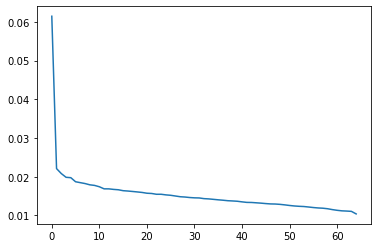

In [14]:
plt.plot(pca.explained_variance_ratio_)

In [20]:
def create_dataset(dataset, look_back=5):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i+look_back])
    return np.array(dataX), np.array(dataY)

def assemble(dat,icol):
    train_loaders, test_loaders = [], []
    
    # for train/test
    train = dat[:12636,icol]
    test = dat[12636:,icol]

    X, y = create_dataset(train, look_back=look_back)
    train_dataset = []
    for i in range(len(X)):
        train_dataset.append((torch.tensor(X[i].reshape(-1,1),dtype=torch.float32),
                              torch.tensor(y[i].reshape(-1,),dtype=torch.float32)))
    train_loaders.append(DataLoader(train_dataset, batch_size=batch_size, drop_last=False))

    X, y = create_dataset(test, look_back=look_back)
    test_dataset = []
    for i in range(len(X)):
        test_dataset.append((torch.tensor(X[i].reshape(-1,1),dtype=torch.float32),
                             torch.tensor(y[i].reshape(-1,),dtype=torch.float32)))
    test_loaders.append(DataLoader(test_dataset, batch_size=batch_size, drop_last=False))
    
    train = dat[:,icol]
    X, y = create_dataset(train, look_back=look_back)
    train_dataset = []
    for i in range(len(X)):
        train_dataset.append((torch.tensor(X[i].reshape(-1,1),dtype=torch.float32),
                              torch.tensor(y[i].reshape(-1,),dtype=torch.float32)))
    train_loaders.append(DataLoader(train_dataset, batch_size=batch_size, drop_last=False))
        
    return train_loaders, test_loaders

In [17]:
criterion = nn.L1Loss()
class MyModel(nn.Module):
    def __init__(self, input_feature, hidden_size, output_feature, num_layers=1):
        super(MyModel, self).__init__()
        self.linear = nn.Linear(input_feature, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True, num_layers=num_layers, dropout=0.2)
        ''' gru input is (N,L,H_in=H_hidden), output is (N,L,H_hidden), hidden is (num_layers, h_hidden)'''
        self.linear_out = nn.Linear(hidden_size, output_feature)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
    
    def forward(self, input, hidden):
        ''' X is in the shape of (N,L,input_feature) '''
        output = F.relu(self.linear(input))
        output, hidden = self.gru(output, hidden)
        output = self.linear_out(F.relu(output))
        return output
    
    def initHidden(self, batch_size):
        return torch.zeros((self.num_layers, batch_size, self.hidden_size))

In [22]:
def evaluate(test_loader):
    model.eval()
    with torch.no_grad():
        loss = 0
        n = 0
        for batch, (x, y) in enumerate(test_loader):
            h0 = model.initHidden(len(x))
            output = model.forward(x, h0)
            loss += criterion(output[:,-1,:],y).item() * len(x)
            n += len(x)
        loss /= n
    return loss

def train(n_epoches, train_loader, test_loader):
    optimizer = optim.Adam(model.parameters())

    best_test_loss = 100.0
    for epoch in range(n_epoches):

        curr_loss = 0.0
        model.train()

        n = 0
        for batch, (x, y) in enumerate(train_loader):
            h0 = model.initHidden(len(x))
            output = model.forward(x, h0)
            #print(output[-1,-1,:],y[-1])
            loss = criterion(output[:,-1,:], y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            curr_loss += loss.item()*len(x)
            n += len(x)

        curr_loss /= len(train_loader.dataset)
        test_loss = evaluate(test_loader)
        if (epoch % 20 == 0):  print(f'current {epoch} training loss={loss.item()} test loss = {test_loss}')
        if test_loss < best_test_loss:
            best_n_epoches = epoch + 1
            best_test_loss = test_loss
            print(f'updating best loss {epoch} training loss={loss.item()} test loss = {test_loss}')

        if epoch > best_n_epoches + 50:
            print('early stop')
            break
    return best_n_epoches

def retrain(n_epoches, train_loader):
    optimizer = optim.Adam(model.parameters())

    model.train()
    for epoch in range(n_epoches):

        curr_loss = 0.0
        for batch, (x, y) in enumerate(train_loader):
            h0 = model.initHidden(len(x))
            output = model.forward(x, h0)
            loss = criterion(output[:,-1,:], y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            curr_loss += loss.item()*len(x)

    curr_loss /= len(train_loader.dataset)
    return curr_loss

In [24]:
for icol in range(65):
    train_loaders, test_loaders = assemble(data_all_pca, icol)
    
    model = MyModel(1, linear_node, 1, num_layers=3)    
    best_n_epoches = train(10, train_loaders[0], test_loaders[0])
    torch.save({'best_epoches': best_n_epoches,
                'model': model.state_dict()},
                'model_pca_train_'+str(icol)+'.pickle')
    
    model = MyModel(1, linear_node, 1, num_layers=3)    
    loss = retrain(best_n_epoches, train_loaders[1])
    torch.save({'loss': loss,
                'best_epoches': best_n_epoches,
                'model': model.state_dict()},
                'model_pca_all_'+str(icol)+'.pickle')

current 0 training loss=1.7029120922088623 test loss = 1.8074543476104736
updating best loss 0 training loss=1.7029120922088623 test loss = 1.8074543476104736
updating best loss 1 training loss=1.518017292022705 test loss = 1.5907343626022339
updating best loss 2 training loss=1.37233304977417 test loss = 1.4240084886550903
updating best loss 3 training loss=1.2918810844421387 test loss = 1.3511874675750732
updating best loss 4 training loss=1.244005799293518 test loss = 1.3190361261367798
updating best loss 5 training loss=1.2235629558563232 test loss = 1.2956069707870483
updating best loss 6 training loss=1.201930284500122 test loss = 1.2684249877929688
updating best loss 7 training loss=1.1919437646865845 test loss = 1.2425135374069214
updating best loss 8 training loss=1.1770130395889282 test loss = 1.2295634746551514
updating best loss 9 training loss=1.1745543479919434 test loss = 1.2066650390625
current 0 training loss=0.9216070175170898 test loss = 0.8999358415603638
updating b

KeyboardInterrupt: 